# STAT3612 Lecture 7 - 	Interpretable Machine Learning

[Dr. Aijun Zhang](http://www.statsoft.org) [STAT3612 Statistical Machine Learning](https://ajzhanghku.github.io/Stat3612/)

20 October 2020

# Load dataset: Boston House Prices (Regression Example)

In [1]:
from sklearn.datasets import load_boston
data = load_boston()
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
x = MinMaxScaler().fit_transform(data.data)
y = MinMaxScaler().fit_transform(data.target.reshape(-1, 1))
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=99)

# Intrinsically Interpretable Models

## GLM (Generalizd Linear Modeling)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
lm.fit(train_x, train_y)

print("LM Training MSE:", mean_squared_error(train_y, lm.predict(train_x)))
print("LM Testing MSE:", mean_squared_error(test_y, lm.predict(test_x)))

LM Training MSE: 0.009790256392621271
LM Testing MSE: 0.013706747565282814


In [4]:
import statsmodels.api as sm

lm = sm.OLS(train_y,sm.add_constant(train_x)).fit()
print(lm.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     84.89
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           2.92e-98
Time:                        20:33:32   Log-Likelihood:                 316.56
No. Observations:                 354   AIC:                            -605.1
Df Residuals:                     340   BIC:                            -551.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5180      0.059      8.752      0.0

In [5]:
print("MLP Training MSE:", mean_squared_error(train_y, lm.predict(sm.add_constant(train_x))))
print("MLP Testing MSE:", mean_squared_error(test_y, lm.predict(sm.add_constant(test_x))))

MLP Training MSE: 0.009790256392621273
MLP Testing MSE: 0.013706747565282831


## Regularized GLM

In [6]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=10, random_state=0).fit(train_x, train_y.ravel())
print(lasso.coef_.round(4))

print("\nLASSO Training MSE:", mean_squared_error(train_y, lasso.predict(train_x)))
print("LASSO Testing MSE:", mean_squared_error(test_y, lasso.predict(test_x)))

[-0.2078  0.1135  0.      0.0495 -0.1318  0.4051  0.0031 -0.3543  0.1323
 -0.1253 -0.1996  0.0669 -0.4997]

LASSO Training MSE: 0.009804775347004949
LASSO Testing MSE: 0.013699383346105005


In [7]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(cv=10, random_state=0, l1_ratio=[.2, .3, .6, .8])
enet.fit(train_x, train_y.ravel())
print(enet.coef_.round(4))

print("\nElasticNet Training MSE:", mean_squared_error(train_y, lasso.predict(train_x)))
print("ElasticNet Testing MSE:", mean_squared_error(test_y, lasso.predict(test_x)))

[-0.1981  0.1099  0.      0.0511 -0.129   0.4022  0.004  -0.3417  0.1294
 -0.1239 -0.2006  0.0678 -0.4937]

ElasticNet Training MSE: 0.009804775347004949
ElasticNet Testing MSE: 0.013699383346105005


## GAM (Generalized Additive Modeling)

In [8]:
!pip install pygam

     |████████████████████████████████| 1.8MB 2.8MB/s 


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


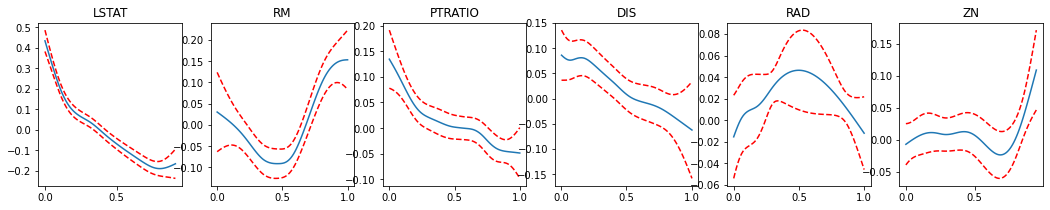

In [9]:
from pygam import LinearGAM,LogisticGAM,l,s,f
import matplotlib.pyplot as plt

gam = LinearGAM(s(12)+s(5)+s(10)+s(7)+s(8)+s(1))
gam.gridsearch(train_x,train_y)

tmpidx = [12, 5, 10, 7, 8, 1]
fig, axes = plt.subplots(1, 6, figsize=(18,3))
titles = data.feature_names
for i, ax in enumerate(axes):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    plt.subplot(axes[i])
    plt.plot(XX[:, tmpidx[i]], pdep)
    plt.plot(XX[:, tmpidx[i]], confi, c='r', ls='--')
    plt.title(titles[tmpidx[i]])

In [10]:
print("\nElasticNet Training MSE:", mean_squared_error(train_y, gam.predict(train_x)))
print("ElasticNet Testing MSE:", mean_squared_error(test_y, gam.predict(test_x)))


ElasticNet Training MSE: 0.0062607844280074074
ElasticNet Testing MSE: 0.011951205119127558


# Black-box Modeling: MLP and XGBoost


In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

mlp = MLPRegressor(hidden_layer_sizes=[20]*4, max_iter=2000,
                    solver='adam', random_state=0, activation="tanh",
                    learning_rate_init=0.01)
mlp.fit(train_x, train_y.ravel())

print("MLP Training MSE:", mean_squared_error(train_y, mlp.predict(train_x)))
print("MLP Testing MSE:", mean_squared_error(test_y, mlp.predict(test_x)))

MLP Training MSE: 0.007444267953665878
MLP Testing MSE: 0.010491683010708667


In [12]:
!pip3 install xgboost

In [13]:
import xgboost 

xgb = xgboost.XGBRegressor()
xgb.fit(train_x,train_y.ravel())

print("XGBoost Training MSE:", mean_squared_error(train_y, xgb.predict(train_x)))
print("XGBoost Testing MSE:", mean_squared_error(test_y, xgb.predict(test_x)))

[20:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Training MSE: 0.0009311761473485179
XGBoost Testing MSE: 0.006808082630737578


# Post-Hoc Model Explanation by InterpretML

In [14]:
!pip install interpret

     |████████████████████████████████| 5.0MB 2.7MB/s 
     |████████████████████████████████| 1.8MB 40.9MB/s 
     |████████████████████████████████| 5.3MB 45.8MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 3.6MB 46.0MB/s 
     |████████████████████████████████| 460kB 48.3MB/s 
     |████████████████████████████████| 276kB 36.2MB/s 
     |████████████████████████████████| 788kB 47.2MB/s 
     |████████████████████████████████| 122kB 41.2MB/s 
     |████████████████████████████████| 860kB 45.0MB/s 
     |████████████████████████████████| 327kB 44.6MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 245kB 47.2MB/s 
     |████████████████████████████████| 1.0MB 42.8MB/s 
     |████████████████████████████████| 3.4MB 42.6MB/s 
     |████████████████████████████████| 194kB 45.2MB/s 
     |████████████████████████████████| 358kB 42.8MB/s 
     |████████████████████████████████| 358kB 33.9MB/

## Blackbox model performance

In [15]:
from interpret import show
from interpret.perf import RegressionPerf

blackbox_perf = RegressionPerf(mlp.predict).explain_perf(train_x, train_y, name='Blackbox')
show(blackbox_perf)

/usr/local/lib/python3.6/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


In [16]:
blackbox_perf = RegressionPerf(xgb.predict).explain_perf(train_x, train_y, name='Blackbox')
show(blackbox_perf)

## Partial Dependence Plot

In [17]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=xgb.predict, data=train_x)
pdp_global = pdp.explain_global(name='Partial Dependence Plot')

show(pdp_global)

## Local Prediction Interpretability

In [18]:
from interpret.blackbox import LimeTabular
from interpret import show

#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=xgb.predict, data=train_x, random_state=0)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(test_x[:3], test_y[:3], name='LIME')

show(lime_local)

# Post-Hoc Local Explanation by LIME

In [19]:
!pip install lime

In [20]:
import lime
import lime.lime_tabular

# define the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_x, feature_names=data.feature_names, 
                                                   verbose=False, mode='regression')
exp = explainer.explain_instance(test_x[0], xgb.predict, num_features=13)
exp.show_in_notebook(show_table=True)

# Post-Hoc Model Explanation by SHAP

In [21]:
!pip install shap

In [22]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(train_x)

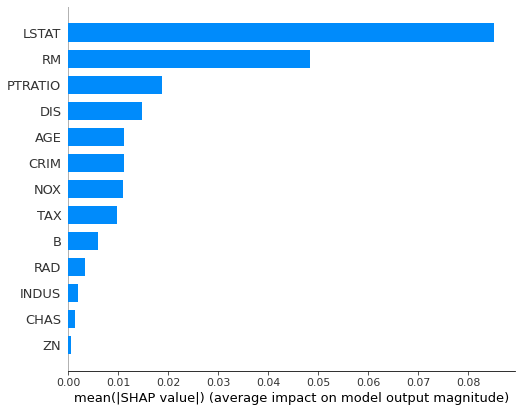

In [23]:
# Variance Importance by SHAP - Version 1
shap.summary_plot(shap_values, train_x, plot_type="bar",feature_names=data.feature_names)

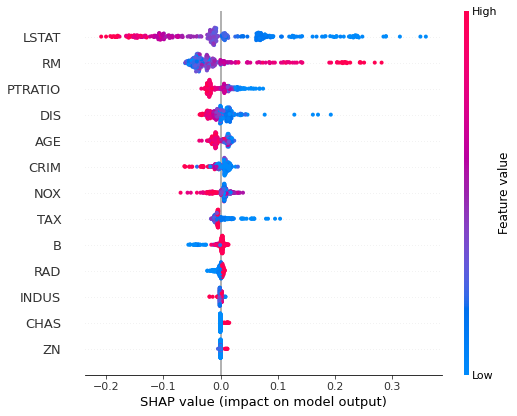

In [24]:
# Variance Importance by SHAP - Version 2
shap.summary_plot(shap_values, train_x, data.feature_names)

In [25]:
# force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], train_x[0], feature_names=data.feature_names)

In [26]:
shap.force_plot(explainer.expected_value, shap_values, train_x, feature_names=data.feature_names)